In [1]:
import cv2
import glob
import numpy as np
import networkx as nx
print('networkx verion : {}'.format(nx.__version__))
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

data_yes = glob.glob('.\\brain_tumor_dataset\\yes\\*.jpg')
data_no = glob.glob('.\\brain_tumor_dataset\\no\\*.jpg')

images, labels = [], []

print('Converting Positive Label Images : \n')
for img_path in tqdm(data_yes, total=len(data_yes)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512, 512))
    images.append(img / 255.)
    labels.append(1)

print('\nConverting Negative Label Image : \n')
for img_path in tqdm(data_no, total=len(data_no)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512, 512))
    images.append(img / 255.)
    labels.append(0)

images = np.asanyarray(images)
labels = np.asanyarray(labels)

networkx verion : 1.11
Converting Positive Label Images : 



  0%|          | 0/154 [00:00<?, ?it/s]


Converting Negative Label Image : 



  0%|          | 0/91 [00:00<?, ?it/s]

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=2022)
print('X_train : {}'.format(X_train.shape))
print('X_test : {}'.format(X_val.shape))
print('y_train : {}'.format(y_train.shape))
print('y_test : {}'.format(y_val.shape))

X_train : (171, 512, 512, 3)
X_test : (74, 512, 512, 3)
y_train : (171,)
y_test : (74,)


In [3]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_pixels_images_data(images, labels):
    plt.figure(figsize=(15, 15))
    for i in tqdm(range(2)):
        imgs = images[np.where(labels == i)]
        lbls = labels[np.where(labels == i)]
        for j in range(8):
            plt.subplot(8, 8,i*8+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(imgs[j], cmap=plt.cm.gray)
            plt.xlabel(lbls[j])
    plt.tight_layout()
    plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

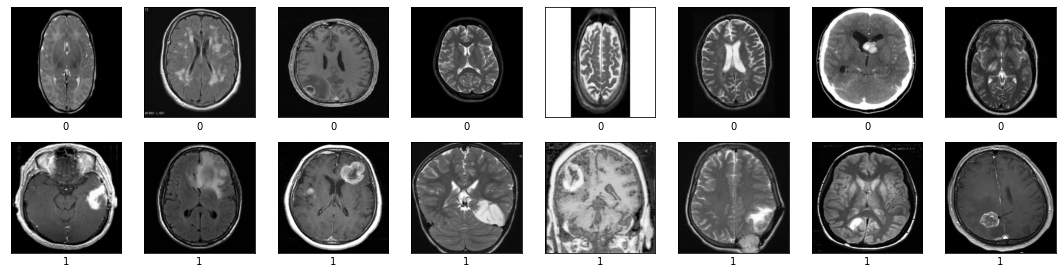

In [4]:
plot_pixels_images_data(X_train, y_train)

In [5]:
import numpy as np
from matplotlib.lines import Line2D
from skimage import color, segmentation

def _preprocess(image):
    if len(image.shape) == 2 or image.shape[2] == 1:
        return color.gray2rgb(
            np.reshape(image, (image.shape[0], image.shape[1])))
    else:
        return image

def quickshift(image, ratio=1, kernel_size=5, max_dist=1, sigma=0):
    image = _preprocess(image)
    return segmentation.quickshift(image=image, ratio=ratio, kernel_size=kernel_size, max_dist=max_dist, sigma=sigma)

def plot_graph_from_image(images, labels, desired_nodes=100, save_in=None, columns = 8, rows = 2):
    # show the output of SLIC
    fig = plt.figure("Superpixels", figsize=(20, 20))
    for i in tqdm(range(rows)):
        imgs = images[np.where(labels == i)]
        lbls = labels[np.where(labels == i)]
        for j in range(columns):
            ax = plt.subplot(8, 8,i*8+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)

            image = _preprocess(imgs[j])

            plt.imshow(image)
            plt.xlabel(lbls[j])
            plt.axis("off")

            segments = segmentation.slic(image, desired_nodes, slic_zero = True)
            asegments = np.array(segments)

            # From https://stackoverflow.com/questions/26237580/skimage-slic-getting-neighbouring-segments

            segments_ids = np.unique(segments)

            # centers
            centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])

            vs_right = np.vstack([segments[:,:-1].ravel(), segments[:,1:].ravel()])
            vs_below = np.vstack([segments[:-1,:].ravel(), segments[1:,:].ravel()])
            bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)

            plt.scatter(centers[:,1],centers[:,0], c='y')

            for k in range(bneighbors.shape[1]):
                try:
                    y0,x0 = centers[bneighbors[0,k]]
                    y1,x1 = centers[bneighbors[1,k]]

                    l = Line2D([x0,x1],[y0,y1], c="w", alpha=0.5)
                    ax.add_line(l)
                except:
                    pass

  0%|          | 0/2 [00:00<?, ?it/s]

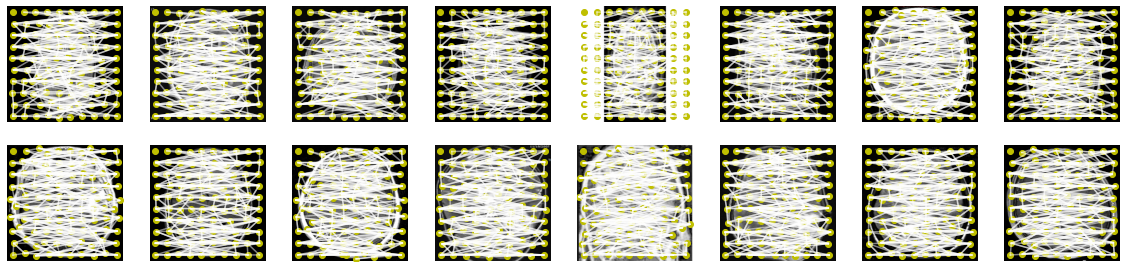

In [6]:
plot_graph_from_image(X_train, y_train)

In [7]:
def plot_graph_only_from_image(images, labels, desired_nodes=100, save_in=None, columns = 8, rows = 2):
    # show the output of SLIC
    fig = plt.figure("Superpixels", figsize=(20, 20))
    for i in tqdm(range(rows)):
        imgs = images[np.where(labels == i)]
        lbls = labels[np.where(labels == i)]
        for j in range(columns):
            ax = plt.subplot(8, 8,i*8+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)

            image = _preprocess(imgs[j])

            segments = segmentation.slic(image, desired_nodes, slic_zero = True)
            asegments = np.array(segments)

            # From https://stackoverflow.com/questions/26237580/skimage-slic-getting-neighbouring-segments

            segments_ids = np.unique(segments)

            # centers
            centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])

            vs_right = np.vstack([segments[:,:-1].ravel(), segments[:,1:].ravel()])
            vs_below = np.vstack([segments[:-1,:].ravel(), segments[1:,:].ravel()])
            bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)

            plt.scatter(centers[:,1],centers[:,0], c='b')

            for k in range(bneighbors.shape[1]):
                try:
                    y0,x0 = centers[bneighbors[0,k]]
                    y1,x1 = centers[bneighbors[1,k]]

                    l = Line2D([x0,x1],[y0,y1], c="k", alpha=0.5)
                    ax.add_line(l)
                except:
                    pass

  0%|          | 0/2 [00:00<?, ?it/s]

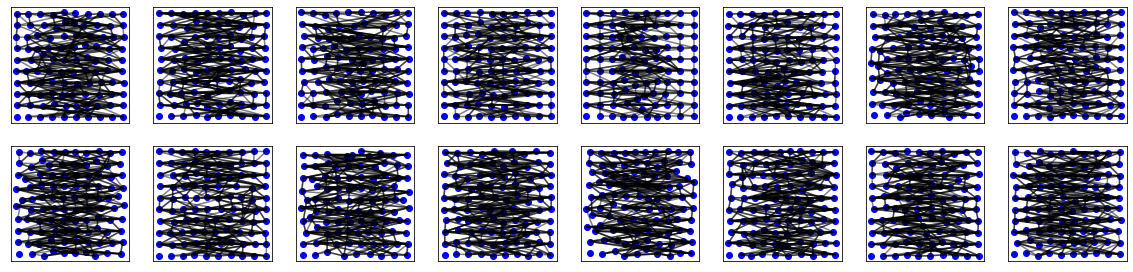

In [8]:
plot_graph_only_from_image(X_train, y_train)

In [9]:
import numpy as np
import networkx as nx
from skimage import color, segmentation

NP_TORCH_FLOAT_DTYPE = np.float32
NP_TORCH_LONG_DTYPE = np.int64

NUM_FEATURES = 5
NUM_CLASSES = 10

def _preprocess(image):
    if len(image.shape) == 2 or image.shape[2] == 1:
        return color.gray2rgb(
            np.reshape(image, (image.shape[0], image.shape[1])))
    else:
        return image

def get_graph_from_image(image, desired_nodes=100):
    # load the image and convert it to a floating point data type
    image = _preprocess(image)
    segments = segmentation.slic(image, desired_nodes, slic_zero = True)
    asegments = np.array(segments)

    num_nodes = np.max(asegments)
    nodes = {
        node: {
            "rgb_list": [],
            "pos_list": []
        } for node in range(num_nodes+1)
    }

    height = image.shape[0]
    width = image.shape[1]
    for y in range(height):
        for x in range(width):
            node = asegments[y,x]
            rgb = image[y,x,:]
            pos = np.array([float(x)/width,float(y)/height])
            nodes[node]["rgb_list"].append(rgb)
            nodes[node]["pos_list"].append(pos)

    G = nx.Graph()
    for node in nodes:
        try:
            nodes[node]["rgb_list"] = np.stack(nodes[node]["rgb_list"])
            nodes[node]["pos_list"] = np.stack(nodes[node]["pos_list"])
            rgb_mean = np.mean(nodes[node]["rgb_list"], axis=0)
            pos_mean = np.mean(nodes[node]["pos_list"], axis=0)
            features = np.concatenate(
                [
                    np.reshape(rgb_mean, -1),
                    np.reshape(pos_mean, -1),
                ]
            )
            G.add_node(node, features = list(features))
        except:
            pass


    # From https://stackoverflow.com/questions/26237580/skimage-slic-getting-neighbouring-segments
    segments_ids = np.unique(segments)

    # centers
    centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])

    vs_right = np.vstack([segments[:,:-1].ravel(), segments[:,1:].ravel()])
    vs_below = np.vstack([segments[:-1,:].ravel(), segments[1:,:].ravel()])
    bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)

    # Adjacency loops
    for i in range(bneighbors.shape[1]):
        if bneighbors[0,i] != bneighbors[1,i]:
            G.add_edge(bneighbors[0,i],bneighbors[1,i])

    # Self loops
    for node in nodes:
        G.add_edge(node,node)

    n = G.number_of_nodes()
    m = G.number_of_edges()
    h = np.zeros([n,NUM_FEATURES]).astype(NP_TORCH_FLOAT_DTYPE)
    edges = np.zeros([2*m,2]).astype(NP_TORCH_LONG_DTYPE)
    # print(G.edges())
    for e,(s,t) in enumerate(G.edges()):
        edges[e,0] = s
        edges[e,1] = t

        edges[m+e,0] = t
        edges[m+e,1] = s

    for i in G.nodes():
        try:
            h[i,:] = list(G.nodes(data='features'))[i][1]['features'][:NUM_FEATURES]
        except:
            pass
    #end for
    del G
    return h[:, 0:], edges

In [10]:
h, e = get_graph_from_image(X_train[0])
h

array([[1.9873003e-02, 1.9873003e-02, 1.9873003e-02, 5.3274438e-02,
        4.7609679e-02],
       [3.5737478e-03, 3.5737478e-03, 3.5737478e-03, 1.6526026e-01,
        4.6790242e-02],
       [3.5641212e-02, 3.5641212e-02, 3.5641212e-02, 2.7426848e-01,
        2.6717981e-02],
       [2.5977066e-01, 2.5977066e-01, 2.5977066e-01, 4.4106638e-01,
        5.0294027e-02],
       [2.6560640e-01, 2.6560640e-01, 2.6560640e-01, 5.4455847e-01,
        5.3295091e-02],
       [3.3082500e-02, 3.3082500e-02, 3.3082500e-02, 7.1470374e-01,
        2.7324306e-02],
       [8.1092771e-03, 8.1092771e-03, 8.1092771e-03, 8.2581133e-01,
        5.1573899e-02],
       [1.9179324e-02, 1.9179324e-02, 1.9179324e-02, 9.4099689e-01,
        4.6431996e-02],
       [6.7796582e-01, 6.7796582e-01, 6.7796582e-01, 6.3826299e-01,
        6.5386020e-02],
       [6.6686481e-01, 6.6686481e-01, 6.6686481e-01, 3.4513444e-01,
        7.3159270e-02],
       [5.9990782e-01, 5.9990782e-01, 5.9990782e-01, 2.2985861e-01,
        1.35

In [11]:
import os
import torch
from tqdm.auto import tqdm
from torch_geometric.data import Data, Dataset

class ImageSuperpixelsDataset(Dataset):
    def __init__(self, root, test=False, transform=None, pre_transform=None):
        self.test = test
        super(ImageSuperpixelsDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return 'ImagesSuperpixels.pt'

    @property
    def processed_file_names(self):
        if self.test:
            return [f'data_test_{i}.pt' for i in range(len(X_val))]
        else:
            return [f'data_{i}.pt' for i in range(len(X_train))]

    def download(self):
        pass

    def process(self):
        if self.test:
            for i, j in tqdm(enumerate(X_val), total=len(X_val)):
                h, edge_index = get_graph_from_image(X_val[i])
                # Create Data Object
                data = Data(x=torch.tensor(h, dtype=torch.float),
                            edge_index=torch.tensor(edge_index).t().to(torch.long).view(2, -1),
                            y=torch.tensor([y_val[i]], dtype=torch.int64))

                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'brain_tumor_data_test_{i}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'brain_tumor_data_{i}.pt'))
        else:
            for i, j in tqdm(enumerate(X_train), total=len(X_train)):
                h, edge_index = get_graph_from_image(X_train[i])

                # Create Data Object
                data = Data(x=torch.tensor(h, dtype=torch.float),
                            edge_index=torch.tensor(edge_index).t().to(torch.long).view(2, -1),
                            y=torch.tensor([y_train[i]], dtype=torch.int64))

                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'brain_tumor_data_test_{i}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'brain_tumor_data_{i}.pt'))

    def len(self):
        if self.test:
            return len(X_val)
        else:
            return len(X_train)

    def get(self, idx):
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, f'brain_tumor_data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, f'brain_tumor_data_{idx}.pt'))
        return data

In [12]:
train_dataset = ImageSuperpixelsDataset(root='data/brain_tumor_graph/')

Processing...


  0%|          | 0/171 [00:00<?, ?it/s]

Done!


In [13]:
test_dataset = ImageSuperpixelsDataset(root='data/brain_tumor_graph/', test=True)

Processing...


  0%|          | 0/74 [00:00<?, ?it/s]

Done!


In [14]:
test_dataset[1]

Data(x=[99, 5], edge_index=[2, 712], y=[1])

In [15]:
train_dataset[0].x

tensor([[1.9873e-02, 1.9873e-02, 1.9873e-02, 5.3274e-02, 4.7610e-02],
        [3.5737e-03, 3.5737e-03, 3.5737e-03, 1.6526e-01, 4.6790e-02],
        [3.5641e-02, 3.5641e-02, 3.5641e-02, 2.7427e-01, 2.6718e-02],
        [2.5977e-01, 2.5977e-01, 2.5977e-01, 4.4107e-01, 5.0294e-02],
        [2.6561e-01, 2.6561e-01, 2.6561e-01, 5.4456e-01, 5.3295e-02],
        [3.3083e-02, 3.3083e-02, 3.3083e-02, 7.1470e-01, 2.7324e-02],
        [8.1093e-03, 8.1093e-03, 8.1093e-03, 8.2581e-01, 5.1574e-02],
        [1.9179e-02, 1.9179e-02, 1.9179e-02, 9.4100e-01, 4.6432e-02],
        [6.7797e-01, 6.7797e-01, 6.7797e-01, 6.3826e-01, 6.5386e-02],
        [6.6686e-01, 6.6686e-01, 6.6686e-01, 3.4513e-01, 7.3159e-02],
        [5.9991e-01, 5.9991e-01, 5.9991e-01, 2.2986e-01, 1.3583e-01],
        [6.1339e-01, 6.1339e-01, 6.1339e-01, 7.5128e-01, 1.3948e-01],
        [2.1992e-02, 2.1992e-02, 2.1992e-02, 1.2841e-01, 1.3314e-01],
        [2.1657e-02, 2.1657e-02, 2.1657e-02, 8.6962e-01, 1.4457e-01],
        [1.1396e-02,

In [16]:
train_dataset[0].edge_index.t()

tensor([[  1,   2],
        [  1,  13],
        [  1,  16],
        ...,
        [ 99,  99],
        [100, 100],
        [  0,   0]])

In [17]:
from torch_geometric.data import DataLoader
NUM_GRAPHS_PER_BATCH = 8
train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

C:\Users\firqa\AppData\Roaming\Python\Python38\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [18]:
next(iter(train_loader))

DataBatch(x=[803, 5], edge_index=[2, 5754], y=[8], batch=[803], ptr=[9])

In [19]:
next(iter(test_loader))

DataBatch(x=[805, 5], edge_index=[2, 5750], y=[8], batch=[805], ptr=[9])

In [20]:
for step, data in enumerate(train_loader):
    if (step + 1) == 6:
        break
    print(f'Step {step + 1}:')
    print('=================')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print(data.x.shape)
    print(data.y.shape)

Step 1:
Number of graphs in the current batch: 8
DataBatch(x=[804, 5], edge_index=[2, 5758], y=[8], batch=[804], ptr=[9])
torch.Size([804, 5])
torch.Size([8])
Step 2:
Number of graphs in the current batch: 8
DataBatch(x=[798, 5], edge_index=[2, 5664], y=[8], batch=[798], ptr=[9])
torch.Size([798, 5])
torch.Size([8])
Step 3:
Number of graphs in the current batch: 8
DataBatch(x=[802, 5], edge_index=[2, 5762], y=[8], batch=[802], ptr=[9])
torch.Size([802, 5])
torch.Size([8])
Step 4:
Number of graphs in the current batch: 8
DataBatch(x=[804, 5], edge_index=[2, 5770], y=[8], batch=[804], ptr=[9])
torch.Size([804, 5])
torch.Size([8])
Step 5:
Number of graphs in the current batch: 8
DataBatch(x=[806, 5], edge_index=[2, 5768], y=[8], batch=[806], ptr=[9])
torch.Size([806, 5])
torch.Size([8])


In [21]:
import torch.nn.functional as F
from torch.nn import Linear, Flatten
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GATConv, GraphConv
from torch.optim.lr_scheduler import ReduceLROnPlateau

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 64
        self.head = 8

        self.conv1 = GATConv(train_dataset.num_features, self.hid, heads=self.head, dropout=0.2)
        self.conv2 = GATConv(self.hid * self.head, self.hid, heads=self.head,
                             dropout=0.2)
        self.conv3 = GATConv(self.hid * self.head, self.hid, heads=self.head,
                             dropout=0.2)
        self.conv4 = GATConv(self.hid * self.head, self.hid, heads=self.head,
                             dropout=0.2)
        self.conv5 = GATConv(self.hid * self.head, self.hid, heads=self.head,
                             dropout=0.2)
        self.flatten = Flatten()
        self.lin = Linear(self.hid * self.head, 10)

    def forward(self, x, edge_index, batch):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.flatten(x)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device :', device)
model = GAT().to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 25)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:
        out = model(data.x.pin_memory().to(device), data.edge_index.pin_memory().to(device), data.batch.pin_memory().to(device))
        loss = criterion(out, data.y.pin_memory().to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x.pin_memory().to(device), data.edge_index.pin_memory().to(device), data.batch.pin_memory().to(device))
        pred = out.argmax(dim=1)
        correct += int((pred == data.y.pin_memory().to(device)).sum())
    return correct / len(loader.dataset)

for epoch in range(0, 300):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

device : cuda
GAT(
  (conv1): GATConv(5, 64, heads=8)
  (conv2): GATConv(512, 64, heads=8)
  (conv3): GATConv(512, 64, heads=8)
  (conv4): GATConv(512, 64, heads=8)
  (conv5): GATConv(512, 64, heads=8)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Linear(in_features=512, out_features=10, bias=True)
)
Epoch: 000, Train Acc: 0.3450, Test Acc: 0.4324
Epoch: 001, Train Acc: 0.6550, Test Acc: 0.5676
Epoch: 002, Train Acc: 0.6550, Test Acc: 0.5676
Epoch: 003, Train Acc: 0.6550, Test Acc: 0.5676
Epoch: 004, Train Acc: 0.6550, Test Acc: 0.5676
Epoch: 005, Train Acc: 0.6550, Test Acc: 0.5676
Epoch: 006, Train Acc: 0.6550, Test Acc: 0.5676
Epoch: 007, Train Acc: 0.6550, Test Acc: 0.5676
Epoch: 008, Train Acc: 0.5029, Test Acc: 0.5811
Epoch: 009, Train Acc: 0.7310, Test Acc: 0.6351
Epoch: 010, Train Acc: 0.6550, Test Acc: 0.5676
Epoch: 011, Train Acc: 0.6550, Test Acc: 0.5811
Epoch: 012, Train Acc: 0.7018, Test Acc: 0.6892
Epoch: 013, Train Acc: 0.6608, Test Acc: 0.5811
Epoch: 014, Train